In [1]:
import torch.nn as nn
import numpy as np
import attack
import torch

## 得到grad和cam

input_tensor.shape = torch.Size([4, 3, 224, 224])
img_np.shape = (4, 224, 224, 3)
self.use_cuda = True


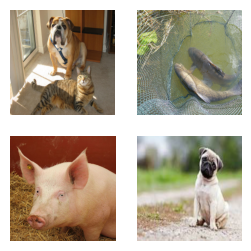

In [2]:
image_folder = './data/images'
model_name = 'ViT'
model, use_cuda, reshape_transform = attack.load_model(model_name)
input_tensor, img, labels = attack.load_images(model, image_folder)
gradcam = attack.GradCAMWrapper(model_name)
predicted_classes, grayscale_cam, grad_of_input = gradcam(input_tensor)
attack.show_images(input_tensor)

In [3]:
print(predicted_classes)
print(grayscale_cam.shape, grad_of_input.shape)
print(np.ndim(grayscale_cam), np.ndim(grad_of_input))


['bull_mastiff', 'sturgeon', 'hog', 'pug']
(4, 224, 224) (4, 224, 224, 3)
3 4


# 进行攻击
1.根据梯度：改变梯度最大的前n个pixel  
2.根据cam：改变heatmap（其实是grayscale_cam）对应的值最大（可视化出来颜色最深）的前n个pixel

In [4]:
def compute_top_indics(input_array, top_num):
    '''
    计算输入数组的前n大的值和位置
    input:
        input_array: 输入数组，shape: (batch, 3, 224,224)
        top_num: 指定算前n大的值
    return: 
        top_array: [batch, 3, 224,224]，前n大的值为1，其余为0
        coordinates: 前n大值的位置, shape: (batch, top_num, dim - 1)
    '''
    batch = input_array.shape[0]
    dim = np.ndim(input_array)
    top_array = np.zeros_like(input_array, dtype=int)
    coordinates = np.zeros((batch, top_num, dim - 1), dtype=int)
    for i in range(batch):
        if dim == 3:
            flattened_image = input_array[i].flatten()
            top_indices = np.argpartition(flattened_image, -top_num)[-top_num:]
            coordinates_tmp = np.column_stack(np.unravel_index(top_indices, input_array.shape[1:]))
            coordinates[i] = coordinates_tmp
            top_array[i].flat[top_indices] = 1 
        elif dim == 4:
            flattened_image = grad_of_input[i].reshape(-1, 3)
            top_indices = np.argpartition(flattened_image, -top_num, axis=None)[-top_num:]
            coordinates_tmp = np.column_stack(np.unravel_index(top_indices, input_array.shape[1:]))
            coordinates[i] = coordinates_tmp
            top_array[i].flat[top_indices] = 1 
            top_array = np.transpose(top_array, (0,3,1,2)) 
        else:
            print('不支持的维度')
        
    return top_array, coordinates

In [5]:
def add_grey_to_channel(input_tensor, grey, ratio):
    """
    将灰度图像的像素值加到输入张量的指定通道上。

    参数:
    - input_tensor: 形状为 (batch_size, num_channels, height, width) 的输入张量。
    - grey: 形状为 (batch_size, height, width) 的灰度图像。
    - channel_idx: 一个包含要将灰度图像添加到的通道索引的数组。

    返回:
    形状为 (batch_size, num_channels, height, width) 的新张量。
    """
    num_channels = input_tensor.shape[1]
    batch_size = input_tensor.shape[0]
    channel_idx = torch.randint(0, num_channels, (batch_size,))
    attacked_tensor = input_tensor.clone()
    for i in range(input_tensor.shape[0]):
        attacked_tensor[i, channel_idx[i], :, :] += grey[i, :, :]*ratio
    return attacked_tensor

In [6]:
def attack_according2top(input_tensor, array, n, ratio, mode = 'top'):
    '''
    input_tensor: 输入的tensor, shape: (batch, 3, 224,224)
    array: 梯度或者cam, shape: (4, 224, 224, 3) 或 (4, 224, 224)
    n: 攻击的像素个数
    ratio: 攻击的强度
    mode: 攻击的模式，top或者random
    '''
    dim = np.ndim(array)
    if mode == 'top':
        top_array, _ = compute_top_indics(array, n)
        if dim == 3:
            attacked_tensor = add_grey_to_channel(input_tensor, top_array, ratio).float()
        elif dim == 4:
            attacked_tensor = (input_tensor[0] + top_array * ratio).float()
        else:
            print('不支持的维度')
    elif mode == 'random':
        shape = input_tensor.shape
        mask = np.zeros(shape)
        one_indices = np.random.choice(np.prod(shape), size=n, replace=False)
        indices = np.unravel_index(one_indices, shape)
        mask[indices] = 1
        attacked_tensor = (input_tensor + mask * ratio).float()
    assert attacked_tensor.shape == input_tensor.shape  
    return attacked_tensor

In [12]:
attacked_tensor = attack_according2top(input_tensor, grad_of_input, 100, 0.5, mode = 'top')

In [23]:
top_array, coordinates = compute_top_indics(grayscale_cam, 100)

In [24]:
top_array.shape, coordinates.shape

((4, 224, 224), (4, 100, 2))

In [21]:
class Attack:
    def __init__(self, input_tensor, array, num, ratio, mode = 'top'):
        '''
        input_tensor: 用于模型输入的tensor, 没有normalize,[batch,3,224,224]tensor
        array: 梯度或者cam, shape: (4, 224, 224, 3) 或 (4, 224, 224)
        num: 攻击的像素个数
        ratio: 攻击的强度
        mode: 攻击的模式，top或者random
        '''
        self.gradcam = attack.GradCAMWrapper(model_name)
        self.input_tensor = input_tensor
        self.num = num
        self.ratio = ratio
        self.mode = mode

    def compute_top_indics(self):
        '''
        计算输入数组的前n大的值和位置
        return: 
            top_array: [batch, 3, 224,224]，前n大的值为1，其余为0
            coordinates: 前n大值的位置, shape: (batch, top_num, dim - 1)
        '''
        batch = self.array.shape[0]
        dim = np.ndim(self.array)
        top_array = np.zeros_like(self.array, dtype=int)
        coordinates = np.zeros((batch, self.num, dim - 1), dtype=int)
        for i in range(batch):
            if dim == 3:
                flattened_image = self.array[i].flatten()
                top_indices = np.argpartition(flattened_image, -self.num)[-self.num:]
            elif dim == 4:
                flattened_image = grad_of_input[i].reshape(-1, 3)
                top_indices = np.argpartition(flattened_image, -self.num, axis=None)[-self.num:]
            else:
                print('不支持的维度')
            coordinates_tmp = np.column_stack(np.unravel_index(top_indices, self.array.shape[1:]))
            coordinates[i] = coordinates_tmp
            top_array[i].flat[top_indices] = 1 
        top_array = np.transpose(top_array, (0,3,1,2)) 
        return top_array, coordinates
    
    def get_attacked_input_tensor(self, array):
        self.array = array
        if self.mode == 'top':
            top_array, _ = self.compute_top_indics()
            attacked_tensor = (self.input_tensor + top_array * self.ratio).float()
        elif self.mode == 'random':
            shape = self.input_tensor.shape
            mask = np.zeros(shape)
            one_indices = np.random.choice(np.prod(shape), size=self.num, replace=False)
            indices = np.unravel_index(one_indices, shape)
            mask[indices] = 1
            attacked_tensor = (self.input_tensor + mask * self.ratio).float()
        assert attacked_tensor.shape == self.input_tensor.shape  
        return attacked_tensor
    
    def predict_and_attack(self, mask='cam'):
        original_classes, grayscale_cam, grad_of_input = self.gradcam(self.input_tensor)
        if mask == 'cam':
            input_array = grayscale_cam
        elif mask == 'grad':
            input_array = grad_of_input
        else:
            raise ValueError("Invalid value for 'mask'. Use 'cam' or 'grad'.")

        self.attacked_tensor = self.get_attacked_input_tensor(input_array)
        loop_count = 0 

        while True:
            predicted_classes, grayscale_cam, grad_of_input = gradcam(self.attacked_tensor)
            if not any(pred_class == orig_class for pred_class, orig_class in zip(predicted_classes, original_classes)):
                break  # 如果全部不相同，跳出循环
            if mask == 'cam':
                input_array = grayscale_cam
            elif mask == 'grad':
                input_array = grad_of_input
            self.attacked_tensor = self.get_attacked_input_tensor(input_array)
            loop_count += 1
        return loop_count, original_classes, predicted_classes, self.attacked_tensor